# PHASE 4 PROJECT - CITY OF CHICAGO ACCIDENTS .

**Authors** : Eugene Maina, Beryl Okelo, Beth Nyambura.

## OVERVIEW

This is a project that aims to build a model to predict the primary causes of road accidents within the City of Chicago.

### Business Problem and Stakeholders.

<img src = 'images\Flag_of_Chicago,_Illinois.svg' width = 200 >

* The City of Chicago Traffic safety board would like to gain further insights of the primary contributory causes of road accidents in the city to help develop targeted interventions.The objective is to build a model that can predict the primary contributory cause of a car accident, given information about the car, the people in the car, the road conditions etc.


* The overall main business questions are:

1. What are the top 10 primary contributors of road accidents?
2. What accidents cause the most fatalities?
3. What period do accidents commonly occur by month?

## DATA UNDERSTANDING

* First step is to load the necessary dependencies and the dataset that will be used to achieve this objective.

In [3]:



# Install missing packages if needed
#%pip install catboost xgboost imbalanced-learn eli5 --quiet

# Importing the necessary dependencies.
# Base dependencies.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Setting the style of the plots
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Machine learning dependencies

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Imbalancing dependencies

from imblearn.under_sampling import RandomUnderSampler

# Interpretability dependencies

import eli5

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')



* Then we have to import and read through the first 5 rows of the dataset to see what we are dealing with.

* The dataset can be found on [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data)



In [5]:
raw_data = pd.read_csv("data/traffic_Crashes.csv")

raw_data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/traffic_Crashes.csv'

* We can also use the pandas `.info()` method to get more information on the dataset.

In [ ]:
# Attaining information on the various columns.

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955502 entries, 0 to 955501
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                955502 non-null  object 
 1   CRASH_DATE_EST_I               69903 non-null   object 
 2   CRASH_DATE                     955502 non-null  object 
 3   POSTED_SPEED_LIMIT             955502 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         955502 non-null  object 
 5   DEVICE_CONDITION               955502 non-null  object 
 6   WEATHER_CONDITION              955502 non-null  object 
 7   LIGHTING_CONDITION             955502 non-null  object 
 8   FIRST_CRASH_TYPE               955502 non-null  object 
 9   TRAFFICWAY_TYPE                955502 non-null  object 
 10  LANE_CNT                       199026 non-null  float64
 11  ALIGNMENT                      955502 non-null  object 
 12  ROADWAY_SURFACE_COND          

* Then we can check for the number of columns that are numerical or categorical.This will be important later on when we have to decide what type of models we would want to deploy.

In [ ]:
# Splitting the data into categorical and numerical columns.

categorical = [col for col in raw_data.columns if raw_data[col].dtype=='object']
numerical = [col for col in raw_data.columns if col not in categorical]

# Then checking the number of columns that are numerical or categorical.
print(f"Number of categorical columns: {len(categorical)}")
print(f"Number of numerical columns: {len(numerical)}")

Number of categorical columns: 31
Number of numerical columns: 17


* Now we can check for the missing values in the columns.First we do the categorical.

In [ ]:
missing_categorical = raw_data[categorical].isnull().sum()
missing_categorical_percentage = np.round(missing_categorical / len(raw_data) * 100, 2)

# Printing the missing values in the categorical columns.
print("Missing values in categorical columns:")
print(pd.DataFrame({
	'Missing Values': missing_categorical,
	'Percentage (%)': missing_categorical_percentage
}))

Missing values in categorical columns:
                         Missing Values  Percentage (%)
CRASH_RECORD_ID                       0            0.00
CRASH_DATE_EST_I                 885599           92.68
CRASH_DATE                            0            0.00
TRAFFIC_CONTROL_DEVICE                0            0.00
DEVICE_CONDITION                      0            0.00
WEATHER_CONDITION                     0            0.00
LIGHTING_CONDITION                    0            0.00
FIRST_CRASH_TYPE                      0            0.00
TRAFFICWAY_TYPE                       0            0.00
ALIGNMENT                             0            0.00
ROADWAY_SURFACE_COND                  0            0.00
ROAD_DEFECT                           0            0.00
REPORT_TYPE                       30754            3.22
CRASH_TYPE                            0            0.00
INTERSECTION_RELATED_I           735809           77.01
NOT_RIGHT_OF_WAY_I               912278           95.48
HIT_AND_R

* Then we do the numerical columns.

In [ ]:
missing_numerical = raw_data[numerical].isnull().sum()
missing_numerical_percentage = np.round(missing_numerical / len(raw_data) * 100, 2)

# Printing the missing values in the numerical columns.
print("Missing values in numerical columns:")
print(pd.DataFrame({
	'Missing Values': missing_numerical,
	'Percentage (%)': missing_numerical_percentage
}))

Missing values in numerical columns:
                               Missing Values  Percentage (%)
POSTED_SPEED_LIMIT                          0            0.00
LANE_CNT                               756476           79.17
STREET_NO                                   0            0.00
BEAT_OF_OCCURRENCE                          5            0.00
NUM_UNITS                                   0            0.00
INJURIES_TOTAL                           2087            0.22
INJURIES_FATAL                           2087            0.22
INJURIES_INCAPACITATING                  2087            0.22
INJURIES_NON_INCAPACITATING              2087            0.22
INJURIES_REPORTED_NOT_EVIDENT            2087            0.22
INJURIES_NO_INDICATION                   2087            0.22
INJURIES_UNKNOWN                         2087            0.22
CRASH_HOUR                                  0            0.00
CRASH_DAY_OF_WEEK                           0            0.00
CRASH_MONTH                      

* We can also use the `.describe()` method to check the distributions of the numerical variables except for the latitude longitude and street_no columns because they represent locations and woulnt provide meaninful information. Also, Beat of occurence relate to Chicago Beat Identification system that the police use to identify time and place of duty.

* We can also create visualisations of these columns to aid our understanding.

In [ ]:
# Describing the data

meaningful_numerical = raw_data[numerical].drop(columns=['LATITUDE', 'LONGITUDE', 'STREET_NO', 'BEAT_OF_OCCURRENCE'])

meaningful_numerical.describe().T

,count,mean,std,min,25%,50%,75%,max
POSTED_SPEED_LIMIT,955502.0,28.422265,6.075317,0.0,30.0,30.0,30.0,99.0
LANE_CNT,199026.0,13.329193,2961.474666,0.0,2.0,2.0,4.0,1191625.0
NUM_UNITS,955502.0,2.035126,0.450828,1.0,2.0,2.0,2.0,18.0
INJURIES_TOTAL,953415.0,0.195711,0.574512,0.0,0.0,0.0,0.0,21.0
INJURIES_FATAL,953415.0,0.001163,0.036893,0.0,0.0,0.0,0.0,4.0
INJURIES_INCAPACITATING,953415.0,0.019392,0.163068,0.0,0.0,0.0,0.0,10.0
INJURIES_NON_INCAPACITATING,953415.0,0.109064,0.425412,0.0,0.0,0.0,0.0,21.0
INJURIES_REPORTED_NOT_EVIDENT,953415.0,0.066092,0.330974,0.0,0.0,0.0,0.0,19.0
INJURIES_NO_INDICATION,953415.0,1.999254,1.155587,0.0,1.0,2.0,2.0,61.0
INJURIES_UNKNOWN,953415.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


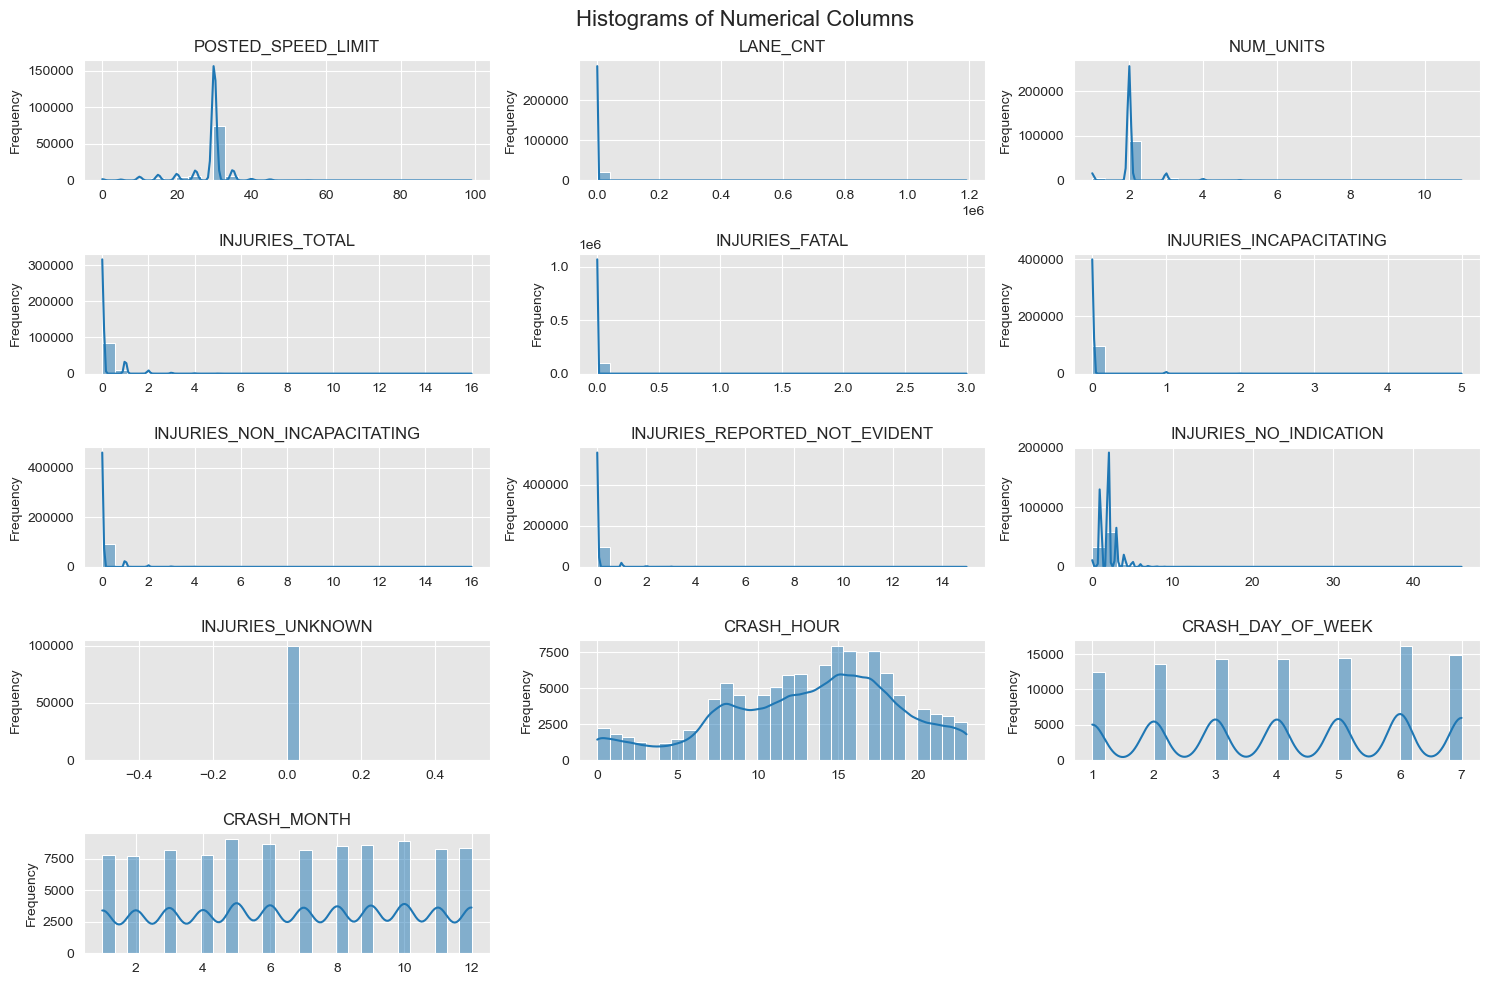

In [ ]:
# Then we visualise these numerical columns in the data using histograms.

plt.figure(figsize=(15, 10))
plot_idx = 1
# Sampling the data for faster plotting and limit bins for speed(since the dataset is too large)
sampled_data = meaningful_numerical.sample(n=100000, random_state=42) if len(meaningful_numerical) > 10000 else meaningful_numerical

for col in sampled_data.columns:
    plt.subplot(5, 3, plot_idx)
    sns.histplot(sampled_data[col].dropna(), kde=True, bins=30)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Frequency')
    plot_idx += 1
plt.suptitle('Histograms of Numerical Columns', fontsize=16)
plt.tight_layout()
plt.show()
plt.savefig('images/numerical_columns_histograms.png', dpi=300, bbox_inches='tight')

* We can also visualise the categorical columns to understand the better.

<Figure size 640x480 with 0 Axes>

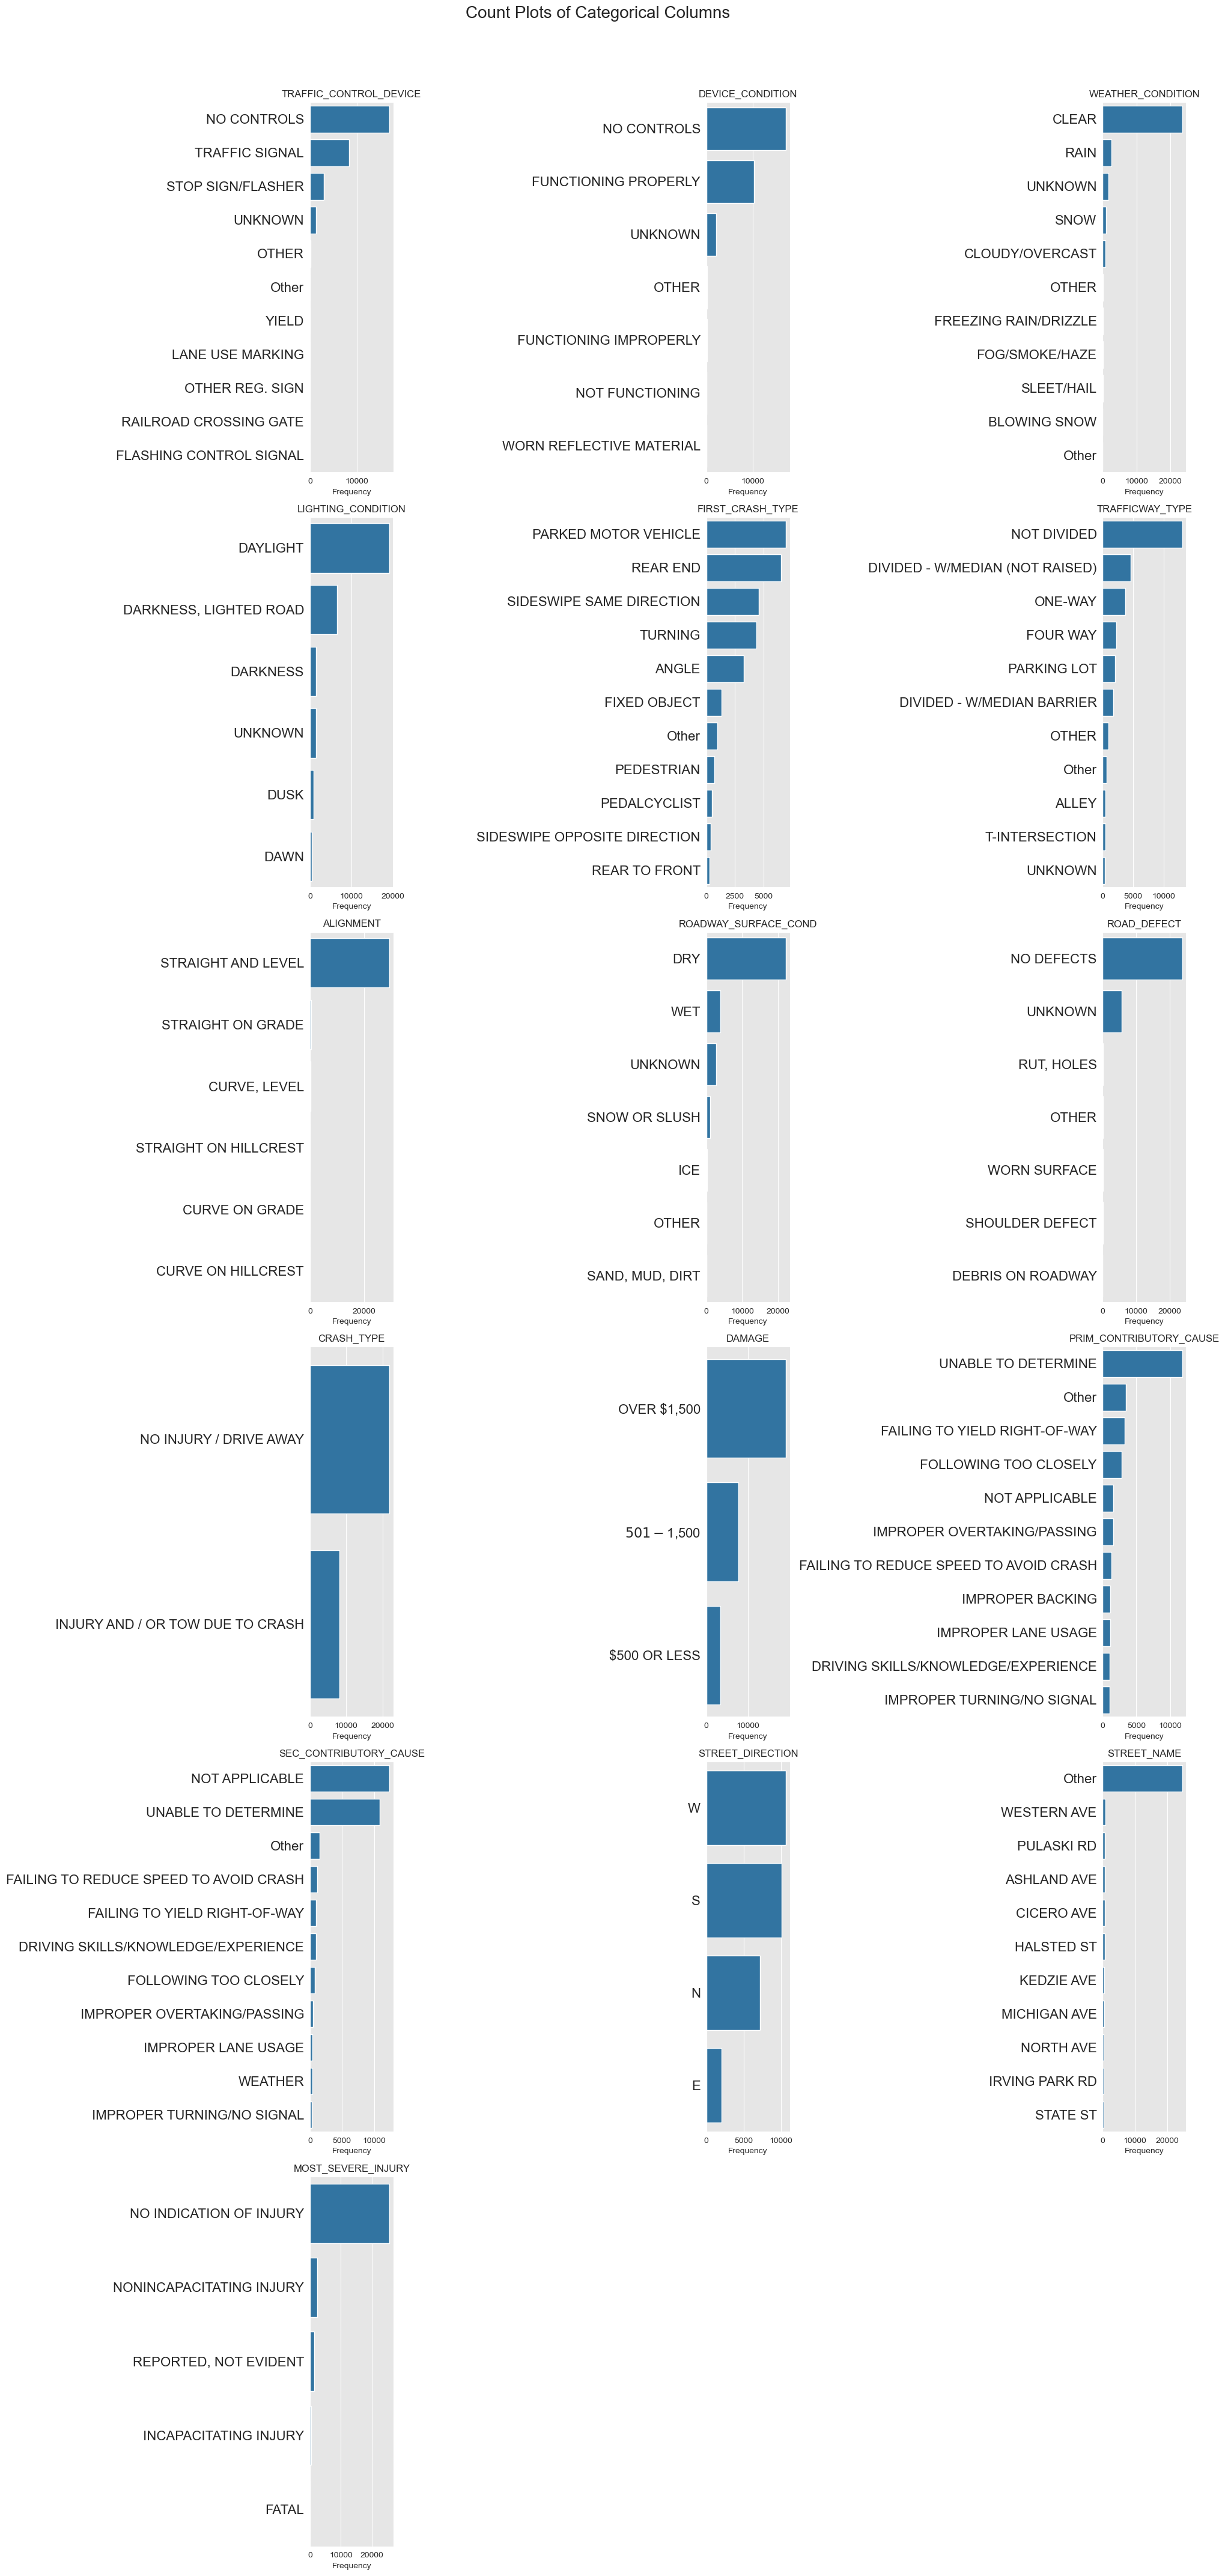

In [ ]:
# Dropping columns like index and date columns that are not useful for analysis.
meaningful_categorical = raw_data[categorical].drop(columns=['CRASH_DATE', 'CRASH_RECORD_ID','CRASH_DATE_EST_I', 'DATE_POLICE_NOTIFIED','LOCATION'])

# Then we visualise these categorical columns in the data using count plots.
categorical_sampled_data = meaningful_categorical.sample(n=30000, random_state=42) if len(meaningful_categorical) > 0 else meaningful_categorical

# Remove columns with more than 1000 missing values before plotting
cols_to_skip = [col for col in categorical_sampled_data.columns if categorical_sampled_data[col].isnull().sum() > 1000]

# Limit the number of unique values to plot for each column to speed up plotting
max_categories = 10

n_cols = 3
cols_to_plot = [col for col in categorical_sampled_data.columns if col not in cols_to_skip]
n_rows = int(np.ceil(len(cols_to_plot) / n_cols))

# Create subplots for each categorical column
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 7 * n_rows), squeeze=False)
axes = axes.flatten()
for idx, col in enumerate(cols_to_plot):
    unique_vals = categorical_sampled_data[col].nunique(dropna=False)
    plot_data = categorical_sampled_data[col]
    if unique_vals > max_categories:
        top_cats = plot_data.value_counts().nlargest(max_categories).index
        plot_data = plot_data.where(plot_data.isin(top_cats), other='Other')
    sns.countplot(y=plot_data, order=plot_data.value_counts().index, ax=axes[idx])
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Frequency')
    axes[idx].set_ylabel('')
    axes[idx].tick_params(axis='y', labelrotation=0, labelsize=16)
for j in range(len(cols_to_plot), len(axes)):
    fig.delaxes(axes[j])
plt.suptitle('Count Plots of Categorical Columns', fontsize=20, y=1.02)
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.tight_layout()
plt.show()
plt.savefig('images/categorical_columns_countplots.png', dpi=300, bbox_inches='tight')


**Understanding and describing the data.**

- The dataset contains over 955,000 records of traffic crashes in Chicago, with 48 columns capturing various aspects of each incident.

- There is a clear distinction between categorical (31 columns) and numerical (17 columns) features, which will guide preprocessing and modeling strategies.

- Several columns have significant missing values, especially among categorical features like `PHOTOS_TAKEN_I`, `STATEMENTS_TAKEN_I`, `DOORING_I`, and `WORKERS_PRESENT_I`, as well as the numerical column `LANE_CNT`.

- Most numerical columns (excluding location and identifier columns) have reasonable completeness and provide information on injuries, crash timing, and road conditions.

- Visualizations of numerical features show the distribution of crash characteristics such as speed limits, number of units involved, and injury counts.

- Categorical feature distributions reveal that some categories dominate (e.g., "NO CONTROLS" for traffic control devices, "CLEAR" for weather), while others are rare or have many missing values.

- The data will require cleaning, imputation, and possibly dimensionality reduction or feature engineering before modeling.

--------

## DATA PREPARATION


To complete our objective it is nessesary to complete some data cleaning and encoding in order to build a good data that can train a classifier.The steps that will be take are:

1. **Handling Missing Values**
    - Impute missing values in numerical columns using strategies such as mean, median or mode.
    - Impute missing values in categorical columns (e.g., `REPORT_TYPE`, `INTERSECTION_RELATED_I`) with the most frequent value or a placeholder like `'Unknown'`.
    - Drop columns with excessive missingness (e.g., `PHOTOS_TAKEN_I`, `DOORING_I`, `WORKERS_PRESENT_I`) if they are not informative.

2. **Feature Selection**
    - Remove identifier columns (`CRASH_RECORD_ID`, `LOCATION`) and date/time columns not useful for modeling.
    - Exclude columns with high cardinality and little predictive value (e.g., `STREET_NAME`), unless feature engineering is applied.

3. **Encoding Categorical Variables**
    - Apply one-hot encoding to nominal categorical features with a manageable number of categories.
    - Use ordinal encoding or target encoding for high-cardinality categorical features if needed.

4. **Scaling Numerical Features**
    - Standardize or normalize numerical features (e.g., `POSTED_SPEED_LIMIT`, `NUM_UNITS`, injury counts) to ensure comparability.

5. **Addressing Class Imbalance**
    - Use techniques such as SMOTE to oversample the minority class in the target variable.

6. **Feature Engineering**
    
    - Combine or bin categories in categorical variables to reduce dimensionality.

7. **Splitting Data**
    - Split the dataset into training and testing sets to evaluate model performance.

-----------

### Data Cleaning and Feature Engineering.

* First we can drop the numerical columns that have more tha 50 % missing values and filling in those with less than 50% with the mode.

In [ ]:
# Dropping columns with more than 50% missing values.
    
def drop_high_missing_values(df, threshold=0.5):
    """
    Drops columns with more than a specified threshold of missing values.
    
    Parameters:
    df : The input DataFrame.
    threshold (float): The threshold for missing values (default is 0.5).
    
    Returns:
    pd.DataFrame: DataFrame with columns dropped if they exceed the threshold.
    """
    # Calculate the percentage of missing values for each column
    missing_percentage = df.isnull().sum() / len(df) * 100
    
    # Identify columns to drop
    cols_to_drop = missing_percentage[missing_percentage > threshold].index
    
    # Drop the identified columns
    df = df.drop(columns=cols_to_drop)

    
    print(f"Dropped {len(cols_to_drop)} columns with more than {threshold*100}% missing values.")
    
    return df

# Dropping columns with more than 50% missing values.
numerical_data = drop_high_missing_values(meaningful_numerical, threshold=0.5)

numerical_data.info()

Dropped 1 columns with more than 50.0% missing values.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955502 entries, 0 to 955501
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   POSTED_SPEED_LIMIT             955502 non-null  int64  
 1   NUM_UNITS                      955502 non-null  int64  
 2   INJURIES_TOTAL                 953415 non-null  float64
 3   INJURIES_FATAL                 953415 non-null  float64
 4   INJURIES_INCAPACITATING        953415 non-null  float64
 5   INJURIES_NON_INCAPACITATING    953415 non-null  float64
 6   INJURIES_REPORTED_NOT_EVIDENT  953415 non-null  float64
 7   INJURIES_NO_INDICATION         953415 non-null  float64
 8   INJURIES_UNKNOWN               953415 non-null  float64
 9   CRASH_HOUR                     955502 non-null  int64  
 10  CRASH_DAY_OF_WEEK              955502 non-null  int64  
 11  CRASH_MONTH                    95550

In [ ]:
# Filling in the numerical columns with less than 50% missing values with the mode.
def fill_with_mode(df):
    """
    Fills numerical columns with less than 50% missing values with the mode.
    
    Parameters:
    df : The input DataFrame.
    
    Returns:
    pd.DataFrame: DataFrame with numerical columns filled with mode.
    """
    # Calculate the percentage of missing values for each column
    missing_percentage = df.isnull().sum() / len(df) * 100
    
    # Identify columns with less than 50% missing values
    cols_to_fill = missing_percentage[missing_percentage < 50].index
    
    # Fill these columns with their respective modes
    for col in cols_to_fill:
        mode_value = df[col].mode(dropna=True)[0]
        # Fill NaN values with the mode (inplace)
        df[col].fillna(mode_value, inplace=True)
    
    print(f"Filled {len(cols_to_fill)} numerical columns with mode where missing values were less than 50%.")
    
    return df

fill_with_mode(numerical_data)

numerical_data.info()

Filled 12 numerical columns with mode where missing values were less than 50%.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955502 entries, 0 to 955501
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   POSTED_SPEED_LIMIT             955502 non-null  int64  
 1   NUM_UNITS                      955502 non-null  int64  
 2   INJURIES_TOTAL                 955502 non-null  float64
 3   INJURIES_FATAL                 955502 non-null  float64
 4   INJURIES_INCAPACITATING        955502 non-null  float64
 5   INJURIES_NON_INCAPACITATING    955502 non-null  float64
 6   INJURIES_REPORTED_NOT_EVIDENT  955502 non-null  float64
 7   INJURIES_NO_INDICATION         955502 non-null  float64
 8   INJURIES_UNKNOWN               955502 non-null  float64
 9   CRASH_HOUR                     955502 non-null  int64  
 10  CRASH_DAY_OF_WEEK              955502 non-null  int64  
 11  CRASH_MONTH 

* Now we do the same for the categorical variables

In [ ]:
# Dropping categorical columns with more than 50% missing values.
def drop_high_missing_categorical(df, threshold=0.5):
    """
    Drops categorical columns with more than a specified threshold of missing values.
    
    Parameters:
    df : The input DataFrame.
    threshold (float): The threshold for missing values (default is 0.5).
    
    Returns:
    pd.DataFrame: DataFrame with categorical columns dropped if they exceed the threshold.
    """
    # Calculate the fraction of missing values for each column
    missing_fraction = df.isnull().sum() / len(df)
    
    # Identify columns to drop
    cols_to_drop = missing_fraction[missing_fraction > threshold].index
    
    # Drop the identified columns
    df = df.drop(columns=cols_to_drop)
    
    print(f"Dropped {len(cols_to_drop)} categorical columns with more than {threshold*100}% missing values.")
    
    return df

meaningful_categorical = drop_high_missing_categorical(meaningful_categorical, threshold=0.5)

meaningful_categorical.info()

Dropped 9 categorical columns with more than 50.0% missing values.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955502 entries, 0 to 955501
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   TRAFFIC_CONTROL_DEVICE   955502 non-null  object
 1   DEVICE_CONDITION         955502 non-null  object
 2   WEATHER_CONDITION        955502 non-null  object
 3   LIGHTING_CONDITION       955502 non-null  object
 4   FIRST_CRASH_TYPE         955502 non-null  object
 5   TRAFFICWAY_TYPE          955502 non-null  object
 6   ALIGNMENT                955502 non-null  object
 7   ROADWAY_SURFACE_COND     955502 non-null  object
 8   ROAD_DEFECT              955502 non-null  object
 9   REPORT_TYPE              924748 non-null  object
 10  CRASH_TYPE               955502 non-null  object
 11  DAMAGE                   955502 non-null  object
 12  PRIM_CONTRIBUTORY_CAUSE  955502 non-null  object
 13  SEC_CON

In [ ]:
# Filling the missing values in the categorical columns with the mode.
def fill_categorical_with_mode(df):
    """
    Fills categorical columns with less than 50% missing values with the mode.
    
    Parameters:
    df : The input DataFrame.
    
    Returns:
    pd.DataFrame: DataFrame with categorical columns filled with mode.
    """
    # Calculate the percentage of missing values for each column
    missing_percentage = df.isnull().sum() / len(df) * 100
    
    # Identify columns with less than 50% missing values
    cols_to_fill = missing_percentage[missing_percentage < 50].index
    
    # Fill these columns with their respective modes
    for col in cols_to_fill:
        mode_value = df[col].mode(dropna=True)[0]
        # Fill NaN values with the mode (inplace)
        df[col].fillna(mode_value, inplace=True)
    
    print(f"Filled {len(cols_to_fill)} categorical columns with mode where missing values were less than 50%.")
    
    return df

meaningful_categorical = fill_categorical_with_mode(meaningful_categorical)
meaningful_categorical.info()

Filled 17 categorical columns with mode where missing values were less than 50%.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955502 entries, 0 to 955501
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   TRAFFIC_CONTROL_DEVICE   955502 non-null  object
 1   DEVICE_CONDITION         955502 non-null  object
 2   WEATHER_CONDITION        955502 non-null  object
 3   LIGHTING_CONDITION       955502 non-null  object
 4   FIRST_CRASH_TYPE         955502 non-null  object
 5   TRAFFICWAY_TYPE          955502 non-null  object
 6   ALIGNMENT                955502 non-null  object
 7   ROADWAY_SURFACE_COND     955502 non-null  object
 8   ROAD_DEFECT              955502 non-null  object
 9   REPORT_TYPE              955502 non-null  object
 10  CRASH_TYPE               955502 non-null  object
 11  DAMAGE                   955502 non-null  object
 12  PRIM_CONTRIBUTORY_CAUSE  955502 non-null  objec

* We can now merge both the primary contributory and secondary comributory cause into one column then we label encode it as it will be out target.

* Then we one hot encode the other categorical variables.



In [ ]:
# Merging the primary contributory and secondary contributory cause into one column.
def merge_contributory_causes(df):
    """
    Merges the primary contributory cause and secondary contributory cause into one column.
    
    Parameters:
    df : The input DataFrame.
    Returns:
    pd.DataFrame: DataFrame with merged contributory causes.
    """
    # Create a new column for merged contributory causes
    df['CONTRIBUTORY_CAUSE'] = df['PRIM_CONTRIBUTORY_CAUSE'].fillna('Unknown') + ' | ' + df['SEC_CONTRIBUTORY_CAUSE'].fillna('Unknown')
    
    # Drop the original contributory cause columns
    df = df.drop(columns=['PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE'])
    
    print("Merged primary and secondary contributory causes into one column.")
    
    return df
meaningful_categorical = merge_contributory_causes(meaningful_categorical)

meaningful_categorical['CONTRIBUTORY_CAUSE'].value_counts().head(10)

Merged primary and secondary contributory causes into one column.


CONTRIBUTORY_CAUSE
UNABLE TO DETERMINE | UNABLE TO DETERMINE                        220454
UNABLE TO DETERMINE | NOT APPLICABLE                             145126
NOT APPLICABLE | NOT APPLICABLE                                   46732
FAILING TO YIELD RIGHT-OF-WAY | NOT APPLICABLE                    41133
FOLLOWING TOO CLOSELY | NOT APPLICABLE                            34690
FAILING TO YIELD RIGHT-OF-WAY | UNABLE TO DETERMINE               23609
FOLLOWING TOO CLOSELY | UNABLE TO DETERMINE                       22131
IMPROPER OVERTAKING/PASSING | NOT APPLICABLE                      18014
IMPROPER BACKING | NOT APPLICABLE                                 16042
FAILING TO YIELD RIGHT-OF-WAY | FAILING TO YIELD RIGHT-OF-WAY     14370
Name: count, dtype: int64

In [ ]:
# Label encoding the contributory cause column.
le = LabelEncoder()
meaningful_categorical['CONTRIBUTORY_CAUSE'] = le.fit_transform(meaningful_categorical['CONTRIBUTORY_CAUSE'])

# Identify columns with low cardinality for one-hot encoding
low_card_cols = [col for col in meaningful_categorical.columns if col != 'CONTRIBUTORY_CAUSE' and meaningful_categorical[col].nunique() < 20]
high_card_cols = [col for col in meaningful_categorical.columns if col != 'CONTRIBUTORY_CAUSE' and meaningful_categorical[col].nunique() >= 20]

# One-hot encode low cardinality columns
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_data = ohe.fit_transform(meaningful_categorical[low_card_cols])
ohe_columns = ohe.get_feature_names_out(low_card_cols)
categorical_encoded = pd.DataFrame(ohe_data, columns=ohe_columns, index=meaningful_categorical.index)

# Label encode high cardinality columns (except the target)
for col in high_card_cols:
	le_col = LabelEncoder()
	categorical_encoded[col] = le_col.fit_transform(meaningful_categorical[col])

# Add the label encoded target
categorical_encoded['CONTRIBUTORY_CAUSE'] = meaningful_categorical['CONTRIBUTORY_CAUSE']

# Resetting the index of the categorical encoded data.
categorical_encoded.reset_index(drop=True, inplace=True)


In [ ]:
categorical_encoded.head()

,TRAFFIC_CONTROL_DEVICE_BICYCLE CROSSING SIGN,TRAFFIC_CONTROL_DEVICE_DELINEATORS,TRAFFIC_CONTROL_DEVICE_FLASHING CONTROL SIGNAL,TRAFFIC_CONTROL_DEVICE_LANE USE MARKING,TRAFFIC_CONTROL_DEVICE_NO CONTROLS,TRAFFIC_CONTROL_DEVICE_NO PASSING,TRAFFIC_CONTROL_DEVICE_OTHER,TRAFFIC_CONTROL_DEVICE_OTHER RAILROAD CROSSING,TRAFFIC_CONTROL_DEVICE_OTHER REG. SIGN,TRAFFIC_CONTROL_DEVICE_OTHER WARNING SIGN,...,STREET_DIRECTION_S,STREET_DIRECTION_W,MOST_SEVERE_INJURY_FATAL,MOST_SEVERE_INJURY_INCAPACITATING INJURY,MOST_SEVERE_INJURY_NO INDICATION OF INJURY,MOST_SEVERE_INJURY_NONINCAPACITATING INJURY,"MOST_SEVERE_INJURY_REPORTED, NOT EVIDENT",TRAFFICWAY_TYPE,STREET_NAME,CONTRIBUTORY_CAUSE
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12,1157,1145
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12,479,1145
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,8,791,607
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1124,1145
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,13,142,1135


* Then we can scale the numerical features with a min max scaler then merge the numerical and categorical features into one dataframe

In [ ]:
# Scaling the numerical features with a MinMaxScaler.
scaler = MinMaxScaler()
numerical_scaled = pd.DataFrame(scaler.fit_transform(numerical_data), columns=numerical_data.columns)

# Concatenating the numerical and categorical features into one dataframe.
final_data = pd.concat([numerical_scaled, categorical_encoded], axis=1)

In [ ]:
final_data.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,...,STREET_DIRECTION_S,STREET_DIRECTION_W,MOST_SEVERE_INJURY_FATAL,MOST_SEVERE_INJURY_INCAPACITATING INJURY,MOST_SEVERE_INJURY_NO INDICATION OF INJURY,MOST_SEVERE_INJURY_NONINCAPACITATING INJURY,"MOST_SEVERE_INJURY_REPORTED, NOT EVIDENT",TRAFFICWAY_TYPE,STREET_NAME,CONTRIBUTORY_CAUSE
0,0.151515,0.058824,0.000000,0.0,0.0,0.0,0.000000,0.032787,0.0,0.043478,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12,1157,1145
1,0.101010,0.058824,0.000000,0.0,0.0,0.0,0.000000,0.032787,0.0,0.869565,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12,479,1145
2,0.303030,0.058824,0.000000,0.0,0.0,0.0,0.000000,0.032787,0.0,0.217391,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,8,791,607
3,0.303030,0.000000,0.047619,0.0,0.0,0.0,0.052632,0.000000,0.0,0.478261,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1124,1145
4,0.303030,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.016393,0.0,0.565217,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,13,142,1135


* Now to declare the features and target variables then perform a split to have a train, test and validation datasets.

In [ ]:
# Declaring the target variable and the features.
X = final_data.drop(columns=['CONTRIBUTORY_CAUSE'])
y = final_data['CONTRIBUTORY_CAUSE']

# Splitting the data into training and testing sets.(Stratified to maintain the distribution of the target variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Splitting the training data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Checking the shape of the training, validation and testing sets.
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}, Test set shape: {X_test.shape}")

Training set shape: (535080, 114), Validation set shape: (133771, 114), Test set shape: (286651, 114)


## DATA MODELLING

In [ ]:
model=LogisticRegression()
model.fit(X_train,y_train)

NameError: name 'LogisticRegression' is not defined

In [ ]:
#Predict on validation set
y_val_pred = model.predict(X_val)

# Validation performance
print("\nValidation Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

## EVALUATION

## CONCLUSIONS

**General Recommendations**

**Best Model**

**Nest Steps**